In [354]:
import os
import torch
import pickle
from tqdm import tqdm
import pickle
import torch
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv
import torch.nn as nn
import torch.nn.functional as F
import os
import pandas as pd
import subprocess
import numpy as np
import torch
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors
import os
from torch_geometric.loader import DataLoader
from pathlib import Path
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import DataLoader, Data
from torch_geometric.nn import GCNConv
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GATConv
import random
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from collections import Counter
from torch_geometric.data import Data, Dataset
import os
from sklearn.metrics import roc_auc_score, average_precision_score, balanced_accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd
import matplotlib.pyplot as plt
from torch_geometric.nn import GATConv, global_mean_pool

%run ../Config.ipynb
config = Config()

from torch_geometric.data import Data, Dataset
from collections import Counter

In [429]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_stacked_bar_chart(df, label_column='label', title='Distribuição', file_name='grafico_empilhado.png', palette = ['#CC8172', '#7D2D1F'] ):
    """
    Plota um gráfico de barras empilhadas com base nas porcentagens de rótulos no DataFrame.

    Parameters:
    - df: DataFrame contendo os dados
    - label_column: Nome da coluna no DataFrame que contém os rótulos
    - title: Título do gráfico
    - file_name: Nome do arquivo onde o gráfico será salvo
    """
    
    # Obtemos a contagem dos labels
    value_counts = df[label_column].value_counts()

    # Calculamos a porcentagem de cada label
    percentages = value_counts / value_counts.sum() * 100

    # Cria um DataFrame para facilitar a manipulação dos dados
    df_plot = pd.DataFrame({
        'Label': percentages.index,
        'Percentual': percentages.values
    })

    # Mapeia os rótulos para "Correct" e "Incorrect"
    df_plot['Label'] = df_plot['Label'].map({1: 'Correct', 0: 'Incorrect'})

    # Ordena o DataFrame para que "Correct" venha antes de "Incorrect"
    df_plot = df_plot.sort_values(by='Label', key=lambda x: x.map({'Correct': 0, 'Incorrect': 1}))

    # Cria uma nova coluna com a porcentagem acumulada para o gráfico empilhado
    df_plot['Percentual acumulado'] = df_plot['Percentual'].cumsum()

    # Cria o gráfico de barras empilhadas
    plt.figure(figsize=(1, 4))

    # Define a paleta de cores
    palette = palette  # "Correct" primeiro, depois "Incorrect"

    # Adiciona barras empilhadas para cada categoria
    bottom = 0
    for i, row in df_plot.iterrows():
        plt.bar(title, row['Percentual'], bottom=bottom, color=palette[i], label=row['Label'])
        bottom += row['Percentual']

    # Adiciona os valores percentuais no topo das barras
    for i, row in df_plot.iterrows():
        plt.text(0, row['Percentual acumulado'] - row['Percentual'] / 2, f'{row["Percentual"]:.1f}%', 
                 ha='center', va='center', color='white')

    # Ajusta a visualização
    plt.xticks([])
    plt.yticks([])
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)
    plt.gca().spines['bottom'].set_visible(False)

    # Adiciona o título ao gráfico
    plt.title(title)

    # Salva o gráfico como PNG com fundo transparente
    plt.savefig(file_name, bbox_inches='tight', pad_inches=0, transparent=True)

    # Mostra o gráfico
    plt.show()


In [430]:
class BipartiteData(Data):
    def __init__(self, edge_index=None, x_s=None, x_t=None, y=None, edge_attr=None, pdb = None, pose = None):
        super().__init__()
        self.edge_index = edge_index
        self.x_s = x_s
        self.x_t = x_t
        self.y = y
        self.edge_attr = edge_attr  # Add edge_attr attribute
        #self.num_nodes = len(set(edge_index[0].tolist())) +  len(set(edge_index[1].tolist()))
        self.num_nodes = (x_s.size(0) if x_s is not None else 0) + (x_t.size(0) if x_t is not None else 0)
        self.pdb = pdb
        self.pose = pose
    
    def __inc__(self, key, value, *args, **kwargs):
        if key == 'edge_index':
            return torch.tensor([[self.x_s.size(0)], [self.x_t.size(0)]])
        else:
            return super().__inc__(key, value, *args, **kwargs)
#bipartite_no_pose_rank_cut_4_coreset_RAND_ENCODED_POSERANK
with open(f'{config.data}/bipartite_data_no_pose_rank_NOT_sorted_by_family_cut_4_coreset_1_RAND.pkl', 'rb') as file:
    dataset_list_opened = pickle.load(file)
len(dataset_list_opened)

##### Filter data list 

filtered_data_list_num_nodes = [data for data in dataset_list_opened if data.num_nodes>0]
filtered_data_list_descriptors = [data for data in filtered_data_list_num_nodes if data.x_s.shape[0] > 0 and data.x_t.shape[0] > 0]
filtered_data_list_descriptors = [data for data in filtered_data_list_descriptors if not data.x_t[1,2].isnan()] 

filtered_data_list = filtered_data_list_descriptors.copy()

label_distribuition = dict(Counter([label.y.tolist() for label in filtered_data_list]))
amount_of_graphs_used_to_train = len(filtered_data_list)

filtered_data_list_descriptors = [data for data in filtered_data_list_descriptors if not data.x_t[1,2].isnan()] 

len(filtered_data_list)

filtered_data_list[0]

class GATModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, batch_size):
        super(GATModel, self).__init__()
        self.conv1 = GATConv(in_channels=input_dim, out_channels=100, heads=2)
        #self.conv2 = GATConv(in_channels=100, out_channels=hidden_dim, heads=1)
        self.fc1 = nn.Linear(100*2, 10)
        
        self.fc3 = nn.Linear(10, 1)
        self.dropout = nn.Dropout(0.1)

    def forward(self, data):
        x_s, x_t, edge_index, distances, x_t_batch, x_s_batch = data.x_s, data.x_t, data.edge_index, data.edge_attr, data.x_t_batch, data.x_s_batch
        x_new_t = self.conv1((x_s, x_t), edge_index, size=(x_s.size(0), x_t.size(0)), edge_attr=distances)
        x = torch.relu(x_new_t)

        ##########3
        #x_new_s = self.conv2((x_t, x_s), edge_index[torch.tensor([1, 0])], size=(x_t.size(0), x_s.size(0)), edge_attr=distances)
        #x = torch.relu(x_new_s)
        #####################Z
        x = global_mean_pool(x, x_s_batch)
        x = self.fc1(x)
        #x = self.fc2(x)

        #x = self.dropout(x)
        x = self.fc3(x)
        #print('x: ', x)
        return x.squeeze()

class BalancedBCEWithLogitsLoss(nn.Module):
    def __init__(self, pos_weight=None, reduction='mean'):
        super(BalancedBCEWithLogitsLoss, self).__init__()
        self.pos_weight = pos_weight
        self.reduction = reduction
        self.bce_loss = nn.BCEWithLogitsLoss(pos_weight=pos_weight, reduction=reduction)

    def forward(self, input, target):
        loss = self.bce_loss(input, target)
        return loss

loader = DataLoader(filtered_data_list[1500:], batch_size=config.model_args["batch_size"], shuffle=True, follow_batch=['x_s', 'x_t'])
criterion = BalancedBCEWithLogitsLoss(pos_weight=torch.tensor(12.34))
#[1500:1938],
import re

def predict(model, data):
    # Preprocess your data here if necessary
    # Convert your data into tensors or any format expected by your model
    # For example:
    model.eval()
    val_probs = {}
    true_label = {}
    # Forward pass through the model
    with torch.no_grad():
        for batch_data in data:
            output = model(batch_data)
            val_probs[str(batch_data.pdb), str(batch_data.pose)] = torch.sigmoid(output).item()  # Obtain probabilities using sigmoid function
            true_label[str(batch_data.pdb), str(batch_data.pose)] =  batch_data.y.item()
    return val_probs, true_label

best_model = GATModel(input_dim=7, hidden_dim=7, batch_size=config.model_args["batch_size"])
best_model.load_state_dict(torch.load('../Model/model_223.pt'))
best_model.eval()
# Make predictions using the best_model and criterion
predictions,true_label = predict(best_model, loader)

/home/lbcb02/anaconda3/lib/python3.11/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [431]:
len(filtered_data_list)

1948

In [432]:
pbs_to_remove_list = [data.pdb for data in filtered_data_list]

#### Convert dictionary to DataFrame

In [433]:
df = pd.DataFrame(predictions.items(), columns=['Index', 'Pred'])
df[['pdb', 'pose']] = df['Index'].apply(lambda x: pd.Series(re.findall(r"'(\w+)'", x[0]) + re.findall(r'\[(\d+)\]', x[1])))
df['label'] = list(true_label.values())
df.drop('Index', axis=1, inplace=True)

In [434]:
df[df['pose'] != '1' ]['label'].value_counts()

0.0    381
1.0     12
Name: label, dtype: int64

In [435]:
df[df['pose'] == '1' ]['label'].value_counts()

0.0    34
1.0    21
Name: label, dtype: int64

In [436]:
general = df.sort_values(['pdb','pose'])

#### Dist plots 

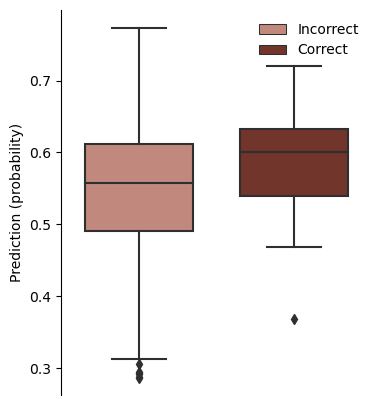

In [437]:
import seaborn as sns
import matplotlib.pyplot as plt

# Definir o tamanho da figura
plt.figure(figsize=(4, 5))  # Ajuste a largura e altura conforme necessário

# Criar o boxplot com ajuste no parâmetro width e customização de dodge
ax = sns.boxplot(data=df, x='label', y='Pred', hue='label', dodge=False, palette=['#CC8172', '#7D2D1F'], width=0.7)

# Ajustar o espaçamento entre os box plots manipulando o parâmetro dodge
# O parâmetro dodge=False faz com que os box plots de diferentes categorias fiquem sobrepostos
# Ajustar o parâmetro width para definir a largura dos box plots
# Ajustar o tamanho da figura com plt.figure(figsize=(largura, altura))

# Remover os eixos superiores, direito e inferior
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Remover os ticks e labels do eixo inferior
ax.xaxis.set_ticks([])
ax.set_xticklabels([])

# Remover o título do gráfico
ax.set_title('')

# Remover o label do eixo x
ax.set_xlabel('')

# Remover o label do eixo x
ax.set_ylabel('Prediction (probability)')


# Remover o fundo da legenda e personalizar os rótulos
handles, _ = ax.get_legend_handles_labels()
ax.legend(handles, ['Incorrect', 'Correct'], frameon=False)

# Salvar o gráfico como um arquivo PNG com fundo transparente
plt.savefig('boxplot_transparente.png', bbox_inches='tight', dpi=300, transparent=True)



<Axes: xlabel='label', ylabel='Pred'>

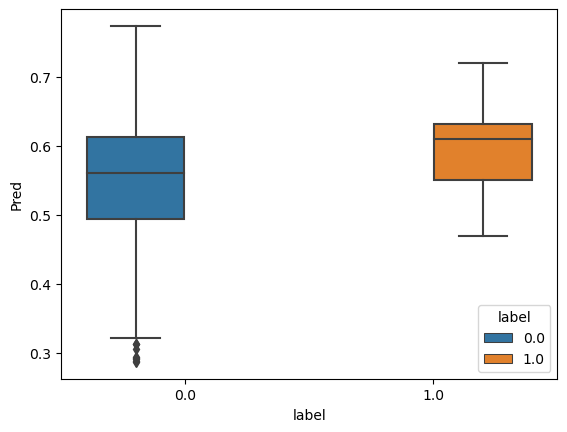

In [438]:
sns.boxplot(data=df[df['pose'] != "1"], x='label', y='Pred', hue='label', dodge=True)

<Axes: xlabel='label', ylabel='Pred'>

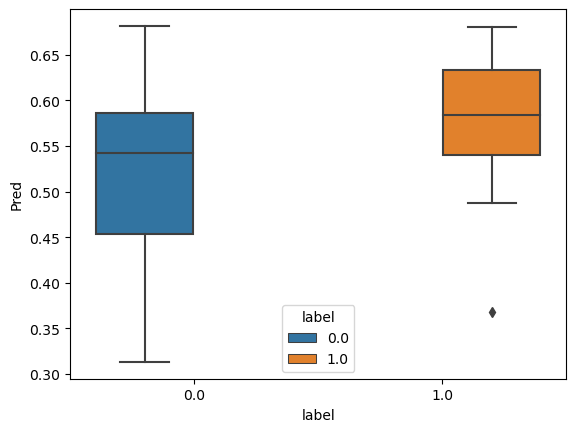

In [439]:
sns.boxplot(data=df[df['pose'] == "1"], x='label', y='Pred', hue='label', dodge=True)

<Axes: xlabel='Pred', ylabel='Density'>

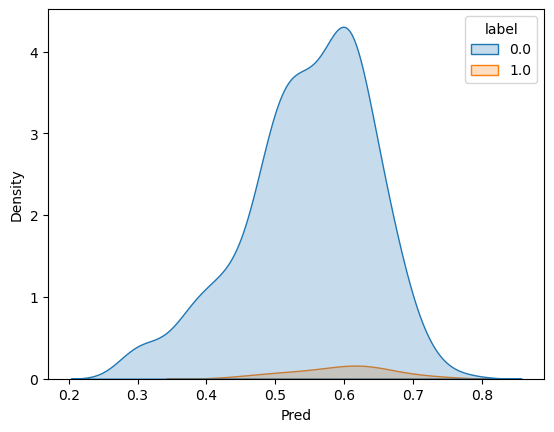

In [440]:
sns.kdeplot(data=df[df['pose'] != "1"], x='Pred', hue='label', fill=True)

<Axes: xlabel='Pred', ylabel='Density'>

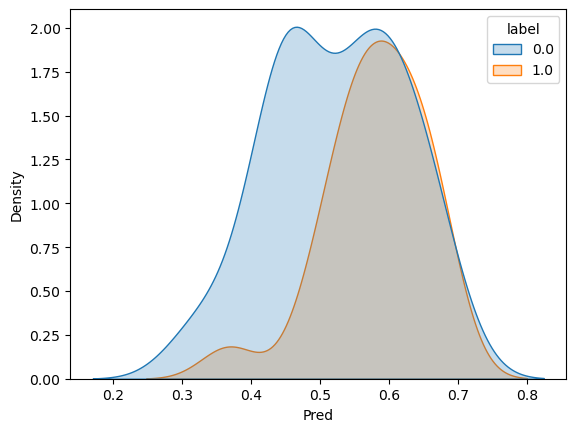

In [441]:
sns.kdeplot(data=df[df['pose'] == "1"], x='Pred', hue='label', fill=True)

#### Top ranked

In [442]:
df = df.sort_values(['pdb','Pred'], ascending = False)
df['label'] = df['label'].astype(int)

In [443]:
top_ranked = df.loc[df.groupby('pdb')['Pred'].idxmax()]

#### My ranking ( RMSD and Scoring): Top sorted by model pred

In [444]:
label_counts = df.groupby('pdb')['label'].sum().sort_values(ascending = False).reset_index()

In [445]:
pdbs_with_pose_1 = list(df[df['pose'] == '1']['pdb'])
#pdbs_teste_set_with_atleast_one_correct_post = list(label_counts[label_counts['label'] > 0 ]['pdb'])

In [446]:
#conjunto =  set(pdbs_teste_set_with_atleast_one_correct_post) and set(pdbs_with_pose_1)
conjunto =  set(pdbs_with_pose_1)

In [447]:
top_ranked.shape

(199, 4)

In [448]:
#top_ranked = top_ranked[top_ranked['pdb'].isin(conjunto)]
top_ranked[top_ranked['label'] == 1].shape[0] / top_ranked.shape[0]

0.09547738693467336

In [449]:
df['pdb'].nunique()

199

In [450]:
top_ranked.shape[0]

199

#### Vina Fraction of top-ranked

In [451]:
#df = df[df['pdb'].isin(conjunto)]

In [452]:
df[(df['pose']=="1") & (df['label']==1)].shape[0] /df['pdb'].nunique()

0.10552763819095477

#### Prediction distribuition 

In [453]:
df['binary_pred'] = df['Pred'].apply(lambda val: 0 if val <= 0.5 else 1)

In [454]:
df['binary_pred'].value_counts()

1    328
0    120
Name: binary_pred, dtype: int64

#### Label distribuition 

In [455]:
df['label'].value_counts(1)

0    0.926339
1    0.073661
Name: label, dtype: float64

#### Comparando resultados 

In [456]:
top_ranked['label'].value_counts(1)

0    0.904523
1    0.095477
Name: label, dtype: float64

In [457]:
top_ranked['label'].value_counts(1)

0    0.904523
1    0.095477
Name: label, dtype: float64

#### Vina score 

In [458]:
vina_score = pd.read_csv('../Datahub/docking_scores_coreset.csv')

In [459]:
general['label'].value_counts()

0.0    415
1.0     33
Name: label, dtype: int64

In [460]:
#general = general[general['pdb'].isin(conjunto)]

In [461]:
general[general['pose'] !='1']['label'].value_counts()

0.0    381
1.0     12
Name: label, dtype: int64

In [462]:
general[general['pose'] =='1']['label'].value_counts()

0.0    34
1.0    21
Name: label, dtype: int64

In [463]:
vina_score['pose'] = vina_score['pose'].astype(str)

In [464]:
merge = pd.merge(vina_score, general, left_on = ['pdb','pose'], right_on = ['pdb','pose'], how = 'outer').dropna()

In [465]:
merge['Pred_vina_score'] =  merge['score'] # - *merge['Pred']  

#### Best ranked 

In [466]:
df = merge.copy()

In [467]:
df.head()

,pdb,pose,score,Pred,label,Pred_vina_score
2,4eor,3,-9.281,0.611110,0.0,-9.281
4,4eor,5,-9.018,0.676989,0.0,-9.018
20,3g2n,2,-9.324,0.644099,0.0,-9.324
23,3g2n,5,-8.044,0.569885,0.0,-8.044
32,1ydr,4,-7.960,0.436474,0.0,-7.960


In [468]:
df = df.sort_values(['pdb','Pred_vina_score'], ascending = False)
df['label'] = df['label'].astype(int)

In [469]:
df[df['pdb'] == '1yc1'].sort_values(['pdb','pose', 'Pred_vina_score']).head(20)

,pdb,pose,score,Pred,label,Pred_vina_score
723,1yc1,1,-9.978,0.681463,0,-9.978
725,1yc1,3,-8.326,0.664400,0,-8.326
730,1yc1,8,-7.613,0.608164,0,-7.613


In [470]:
top_ranked = df.loc[df.groupby('pdb')['Pred_vina_score'].idxmin()]

In [471]:
#top_ranked = top_ranked[top_ranked['pdb'].isin(conjunto)]
top_ranked[top_ranked['label'] == 1].shape[0] / top_ranked.shape[0]

0.15384615384615385

In [472]:
top_ranked[top_ranked['label'] == 1].shape[0]

30

In [473]:
top_ranked.shape

(195, 6)

In [474]:
general.shape

(448, 4)

In [475]:
general[(general['pose']=="1")].shape

(55, 4)

In [476]:
general[(general['pose']=="1") & (general['label']==1)].shape[0]

21

#### Report 

#### label (Pose != 1) 

0:381,
1: 12

#### Pose == 1 classe == 1

21


#### Pose != 1 classe == 1

12


Então o dataframe para ser reranquedo precisaria ter as 33 poses. Qual é esse dataframe? 

#### label (Pose == 1) 

0: 34,
1: 21

#### Results 

In [477]:
teste = df.copy()
teste = teste.sort_values('pdb')

In [478]:
teste.shape

(430, 6)

In [479]:
pose_1 = teste[teste['pose'] =='1']

In [480]:
pose_1['label'].value_counts()

0    34
1    21
Name: label, dtype: int64

In [481]:
pose_1[pose_1['Pred'] > 0.6]['label'].value_counts()

1    10
0     8
Name: label, dtype: int64

In [482]:
pose_1[pose_1['Pred'] > 0.5]['label'].value_counts()

1    19
0    18
Name: label, dtype: int64

In [483]:
pose_1[pose_1['Pred'] > 0.55]['label'].value_counts(1)

0    0.5
1    0.5
Name: label, dtype: float64

In [484]:
palette=['#7D2D1F', '#CC8172']

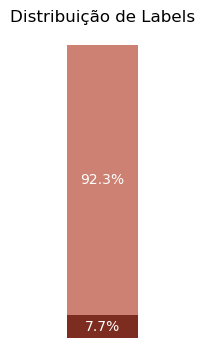

In [485]:
plot_stacked_bar_chart(teste, label_column='label', title='Distribuição de Labels', file_name='grafico_empilhado_before.png')

In [486]:
teste['label'].value_counts()

0    397
1     33
Name: label, dtype: int64

In [487]:
teste[teste['Pred'] > 0.45]['label'].value_counts()

0    335
1     32
Name: label, dtype: int64

In [488]:
teste['label'].value_counts()

0    397
1     33
Name: label, dtype: int64

In [489]:
teste[teste['Pred'] > 0.5]['label'].value_counts()

0    284
1     30
Name: label, dtype: int64

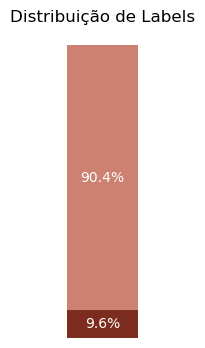

In [490]:
plot_stacked_bar_chart(teste[teste['Pred'] > 0.5], label_column='label', title='Distribuição de Labels', file_name='grafico_empilhado_before.png')

#### Pose 1 

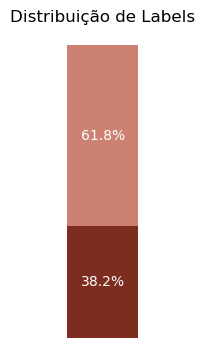

In [491]:
plot_stacked_bar_chart(pose_1, label_column='label', title='Distribuição de Labels', file_name='grafico_empilhado_before_pose_1.png')

In [492]:
pose_1['label'].value_counts()

0    34
1    21
Name: label, dtype: int64

In [493]:
pose_1[pose_1['Pred'] > 0.5]['label'].value_counts()

1    19
0    18
Name: label, dtype: int64

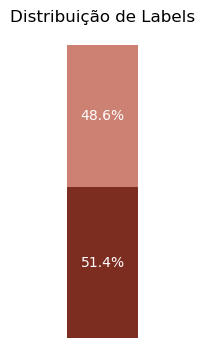

In [497]:
plot_stacked_bar_chart(pose_1[pose_1['Pred'] > 0.50], label_column='label', title='Distribuição de Labels', file_name='grafico_empilhado_pose_1.png', palette = ['#7D2D1F', '#CC8172'])

## New validation 

In [313]:
name = 'NO_POSERANK_cut_4_REFINED_SET_05_06_2024.pkl'
with open(f'{config.data}/{name}', 'rb') as file:
    dataset_list_opened = pickle.load(file)
len(dataset_list_opened)

27651

In [314]:
dataset_list_opened[:20]

[BipartiteData(edge_index=[2, 56], x_s=[56, 7], x_t=[56, 7], y=0.0, edge_attr=[56], num_nodes=112, pdb='4kfq', pose=5),
 BipartiteData(edge_index=[2, 77], x_s=[77, 7], x_t=[77, 7], y=0.0, edge_attr=[77], num_nodes=154, pdb='5byi', pose=8),
 BipartiteData(edge_index=[2, 72], x_s=[72, 7], x_t=[72, 7], y=0.0, edge_attr=[72], num_nodes=144, pdb='6e5l', pose=2),
 BipartiteData(edge_index=[2, 110], x_s=[110, 7], x_t=[110, 7], y=0.0, edge_attr=[110], num_nodes=220, pdb='5d3h', pose=5),
 BipartiteData(edge_index=[2, 126], x_s=[126, 7], x_t=[126, 7], y=1.0, edge_attr=[126], num_nodes=252, pdb='1ejn', pose=3),
 BipartiteData(edge_index=[2, 132], x_s=[132, 7], x_t=[132, 7], y=0.0, edge_attr=[132], num_nodes=264, pdb='5oa6', pose=9),
 BipartiteData(edge_index=[2, 86], x_s=[86, 7], x_t=[86, 7], y=0.0, edge_attr=[86], num_nodes=172, pdb='4u73', pose=7),
 BipartiteData(edge_index=[2, 127], x_s=[127, 7], x_t=[127, 7], y=0.0, edge_attr=[127], num_nodes=254, pdb='5kr2', pose=5),
 BipartiteData(edge_inde

In [186]:
Counter([data.y.tolist() for data in dataset_list_opened[:10000]])

Counter({0.0: 9182, 1.0: 818})

In [187]:
9182/818

11.224938875305623

In [88]:
#bipartite_no_pose_rank_cut_4_coreset_RAND_ENCODED_POSERANK
with open(f'{config.data}/NO_POSERANK_cut_4_REFINED_SET_05_06_2024.pkl', 'rb') as file:
    dataset_list_opened = pickle.load(file)
len(dataset_list_opened)

27651

In [89]:
dataset_list_opened = [data for data in dataset_list_opened if data.pdb not in pbs_to_remove_list]

In [90]:
##### Filter data list 

filtered_data_list_num_nodes = [data for data in dataset_list_opened if data.num_nodes>0]
filtered_data_list_descriptors = [data for data in filtered_data_list_num_nodes if data.x_s.shape[0] > 0 and data.x_t.shape[0] > 0]
filtered_data_list_descriptors = [data for data in filtered_data_list_descriptors if not data.x_t[1,2].isnan()] 

filtered_data_list = filtered_data_list_descriptors.copy()

label_distribuition = dict(Counter([label.y.tolist() for label in filtered_data_list]))
amount_of_graphs_used_to_train = len(filtered_data_list)

filtered_data_list_descriptors = [data for data in filtered_data_list_descriptors if not data.x_t[1,2].isnan()] 

len(filtered_data_list)

filtered_data_list[0]


loader = DataLoader(filtered_data_list[:1000], batch_size=config.model_args["batch_size"], shuffle=True, follow_batch=['x_s', 'x_t'])
criterion = BalancedBCEWithLogitsLoss(pos_weight=torch.tensor(11.22))


best_model = GATModel(input_dim=7, hidden_dim=7, batch_size=config.model_args["batch_size"])
best_model.load_state_dict(torch.load('../Model/model_223.pt'))
best_model.eval()
# Make predictions using the best_model and criterion
predictions,true_label = predict(best_model, loader)

/home/lbcb02/anaconda3/lib/python3.11/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [91]:
df = pd.DataFrame(predictions.items(), columns=['Index', 'Pred'])
df[['pdb', 'pose']] = df['Index'].apply(lambda x: pd.Series(re.findall(r"'(\w+)'", x[0]) + re.findall(r'\[(\d+)\]', x[1])))
df['label'] = list(true_label.values())
df.drop('Index', axis=1, inplace=True)

In [92]:
df.head()

,Pred,pdb,pose,label
0,0.590323,2xm2,3,0.0
1,0.284823,5hbs,5,0.0
2,0.492983,1h6h,3,0.0
3,0.520624,5e2o,2,0.0
4,0.534146,4bco,7,0.0


In [93]:
pose_1 = df[df['pose'] =='1']

In [94]:
pose_1['label'].value_counts()

0.0    67
1.0    31
Name: label, dtype: int64

In [95]:
pose_1['label'].value_counts(1)

0.0    0.683673
1.0    0.316327
Name: label, dtype: float64

In [96]:
#pose_1[pose_1['Pred'] > 0.6]['label'].value_counts()

In [97]:
pose_1[pose_1['Pred'] > 0.6]['label'].value_counts(1)

0.0    0.677419
1.0    0.322581
Name: label, dtype: float64

In [98]:
pose_1[pose_1['Pred'] > 0.5]['label'].value_counts()

0.0    47
1.0    24
Name: label, dtype: int64

In [99]:
pose_1[pose_1['Pred'] > 0.5]['label'].value_counts(1)

0.0    0.661972
1.0    0.338028
Name: label, dtype: float64

In [100]:
pose_1[pose_1['Pred'] > 0.55]['label'].value_counts(1)

0.0    0.66
1.0    0.34
Name: label, dtype: float64

In [1]:
1802/146

12.342465753424657